In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 이미지 처리
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# 파일 존재 여부 확인용
import os

In [4]:
# 랜덤숫자 생성
import random

In [5]:
# 모델
from tensorflow import keras

In [6]:
# 클러스터링
from scipy.cluster import hierarchy # hierarchical clustering

# 디렉토리 설정

In [7]:
os.chdir('/content/drive/MyDrive/[perst]데이터셋/MachineLearningProject/01_Cloth Detection Model')

In [8]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1IE_8n95r-2qLINUcooIi9SdGkw55753B/[perst]데이터셋/MachineLearningProject/01_Cloth Detection Model'

# 변수 목록

In [9]:
test_dir_name = "./Dataset/Train-Test_All/Test/"

img_width = 200
img_height = 200

model_dir_name = './Model/' # 학습 모델이 저장될 디렉토리명

In [10]:
palette = [0,0,0,
          255,0,0,
          0,255,0,
          0,0,255,
          255,255,0]

In [11]:
label_string = "0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece"

# 사용 모델 버전

In [13]:
bg_model_path = model_dir_name + "binary_poly_seg_model_0113_01.keras"
part_model_path = model_dir_name + 'poly_seg_model_0331_01.keras'

# 이미지 불러오고 ori_list에 저장

In [15]:
ori_list = []

while len(ori_list)<10:
  # Test 데이터의 1~2000 파일 랜덤으로 불러오기
  rand_num = random.randint(1, 2000)

  img_path = test_dir_name + "Image/" + str(rand_num) + ".jpg"

  if not os.path.isfile(img_path):
    continue

  # 이미지 파일 로드
  img_file = cv2.imread(img_path)
  if img_file is None:
    print(str(rand_num) + ".jpg File Load Failed!!")
    break

  # 이미지 파일의 색상값을 RGB 형식으로 변경
  img_file = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)

  ori_list.append(img_file)
  print(str(len(ori_list)) + " : " + str(rand_num))

print("Complete")

1 : 557
2 : 1707
3 : 62
4 : 1050
5 : 385
6 : 269
7 : 705
8 : 1155
9 : 939
10 : 244
Complete


In [16]:
ori_list = np.array(ori_list)
ori_list.shape

(10, 200, 200, 3)

0


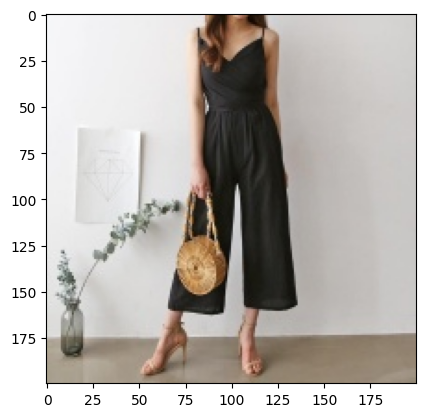

1


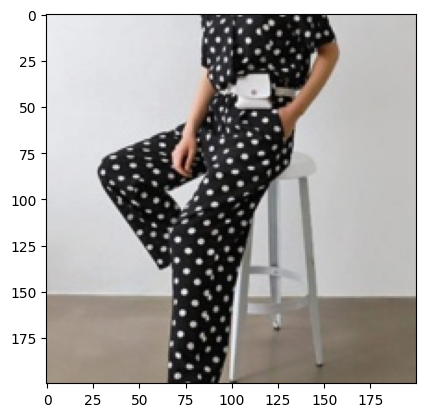

2


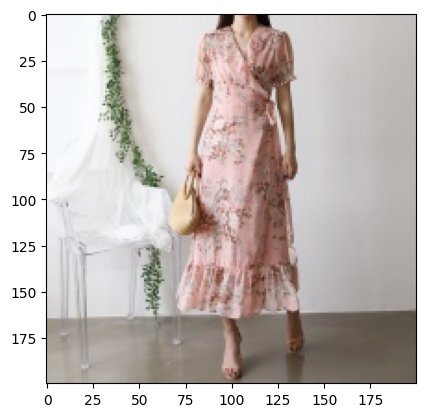

3


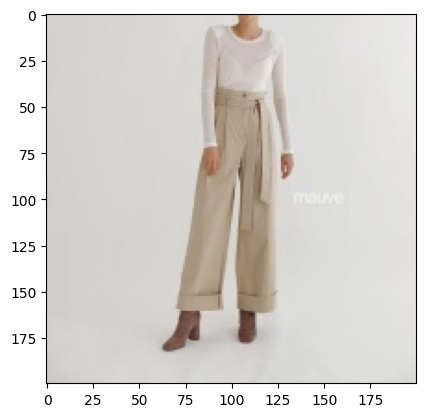

4


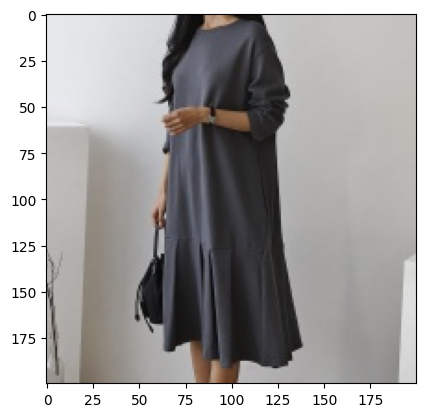

5


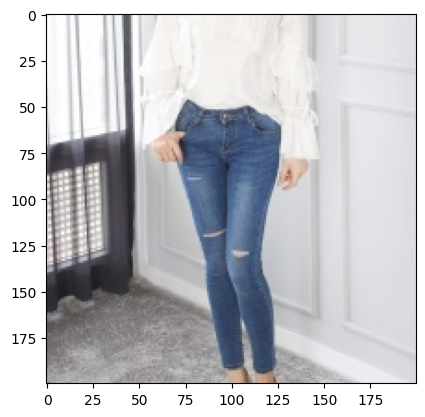

6


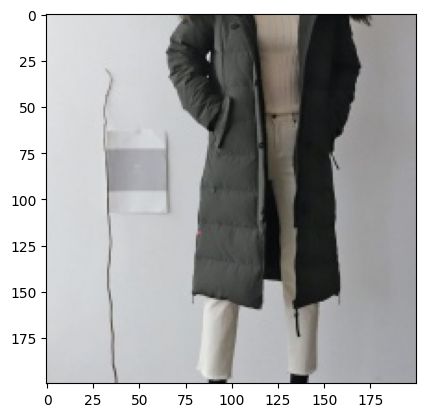

7


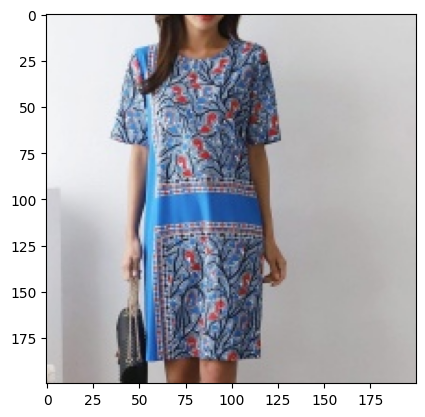

8


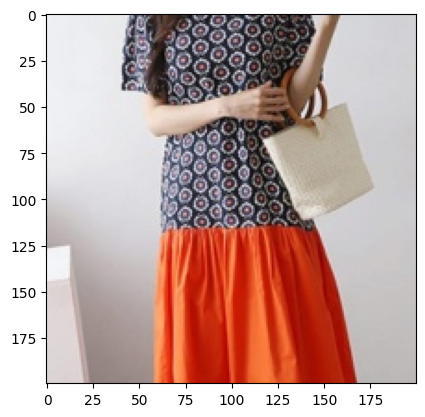

9


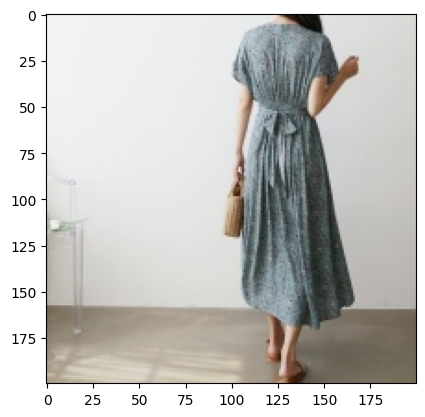

In [18]:
for i in range(len(ori_list)):
  print(i)
  plt.imshow(ori_list[i])
  plt.show()

# 배경 제거하고 no_bg_list에 저장

In [19]:
bg_model = keras.models.load_model(bg_model_path)
bg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 200, 32)         2432      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 200, 200, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 200, 200, 32)         9248      ['dropout[0][0]']             
                                                                                              

In [20]:
bg_preds = bg_model.predict(ori_list)

1/1 [==============================] - 3s 3s/step


In [22]:
# 예측 결과를 마스크로 생성하고 no_bg_list에 저장
no_bg_list = []
del_list = []

for i in range(0, len(bg_preds)):
    bg_mask = np.ndarray.round(bg_preds[i])
    bg_mask = bg_mask.astype('uint8')

    # 이미지 영역 전체가 마스크 처리됐을 경우
    if (1 not in np.unique(bg_mask)):
      print(str(i) + " image has no data")
      del_list.append(i)
      continue
    else:
      no_bg_image = cv2.bitwise_and(ori_list[i], ori_list[i], mask=bg_mask)
      no_bg_list.append(no_bg_image)


for i in del_list:
  del ori_list[i]

print("Complete")

Complete


In [23]:
no_bg_list = np.array(no_bg_list)
no_bg_list.shape

(10, 200, 200, 3)

0


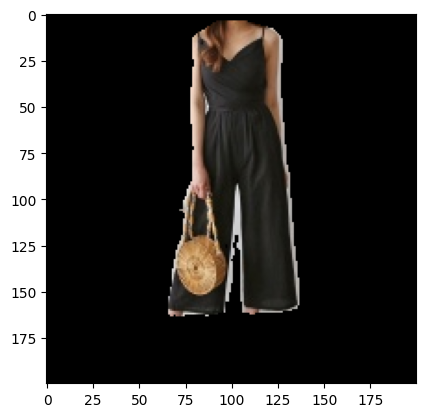

1


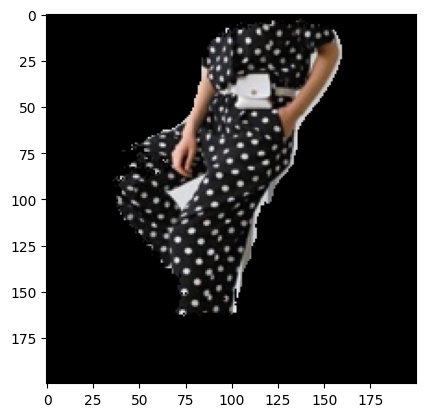

2


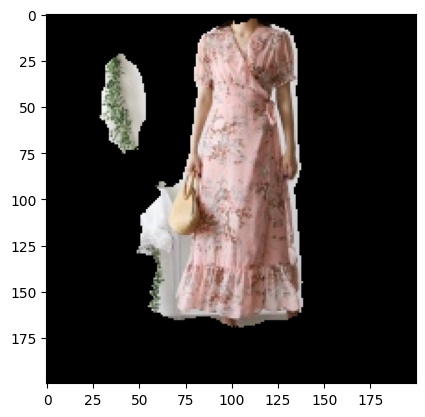

3


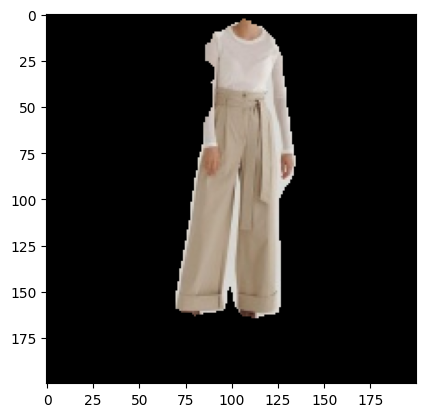

4


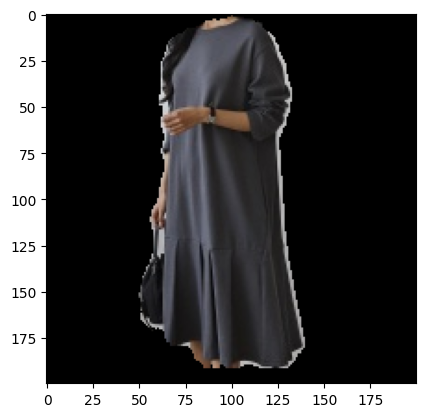

5


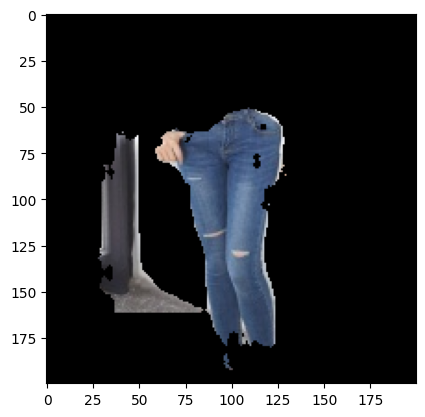

6


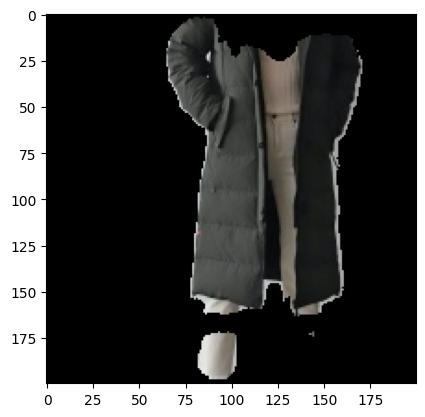

7


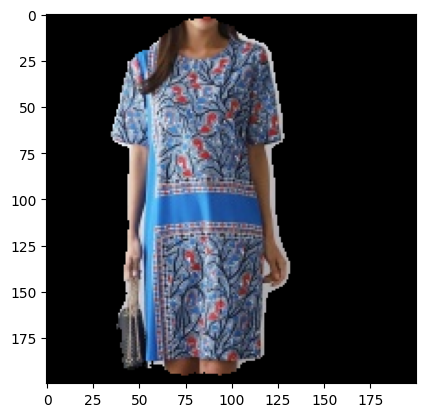

8


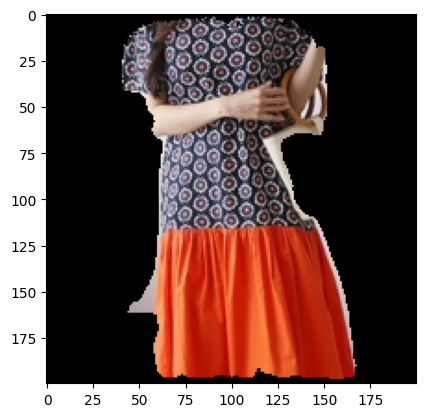

9


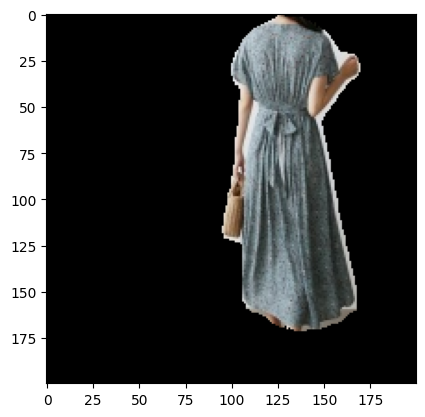

In [25]:
for i in range(len(no_bg_list)):
  print(i)
  plt.imshow(no_bg_list[i])
  plt.show()

# 파트별 마스크 생성하고 part_list에 저장

In [26]:
part_model = keras.models.load_model(part_model_path)
part_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 200, 32)         2432      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 200, 200, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 200, 200, 32)         9248      ['dropout[0][0]']             
                                                                                              

In [41]:
part_preds = part_model.predict(no_bg_list)

1/1 [==============================] - 3s 3s/step


In [51]:
# 예측 결과를 마스크로 생성하고 part_list에 저장

part_list = part_preds.argmax(axis=-1)
part_list.shape

(10, 200, 200)

0
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


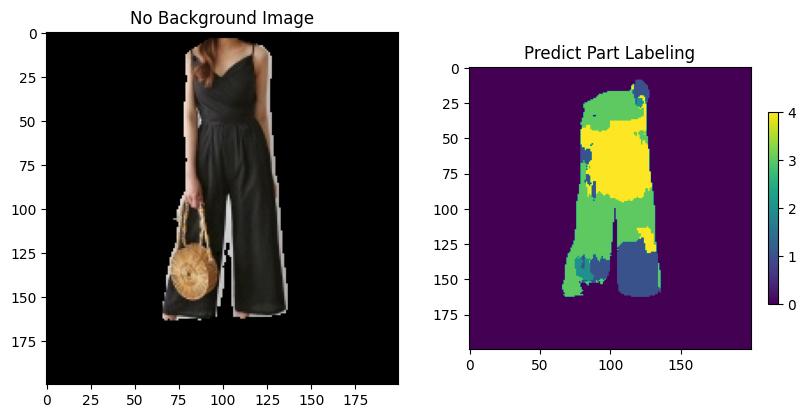

1
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


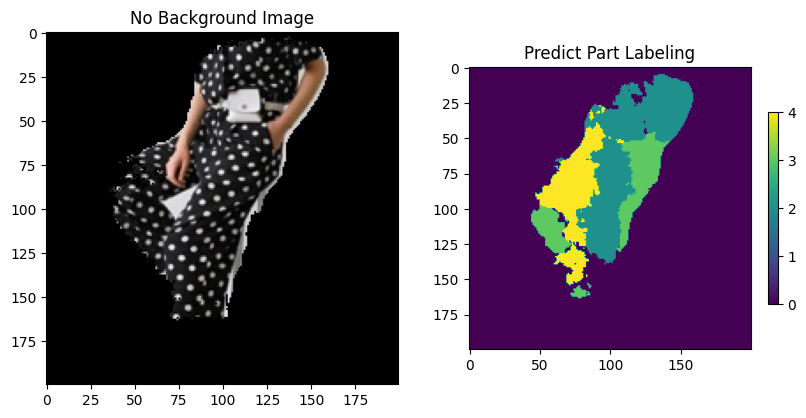

2
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


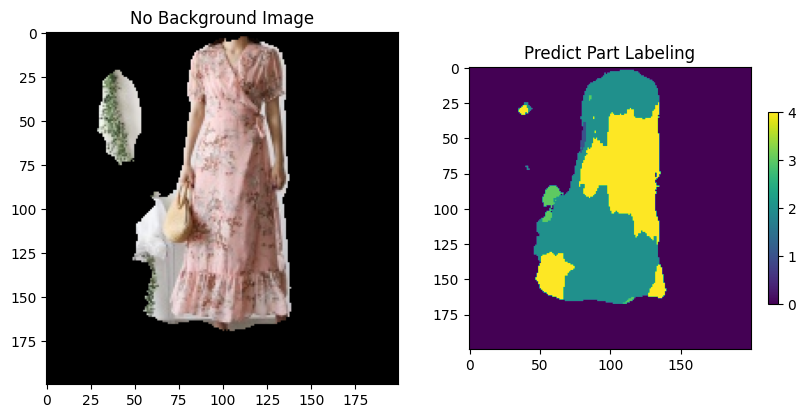

3
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


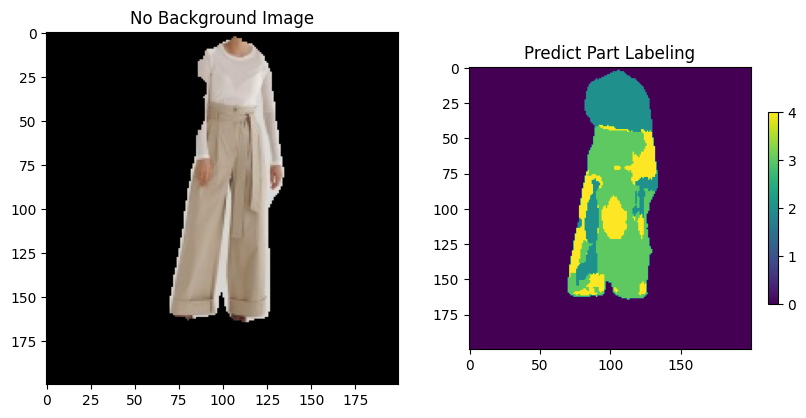

4
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


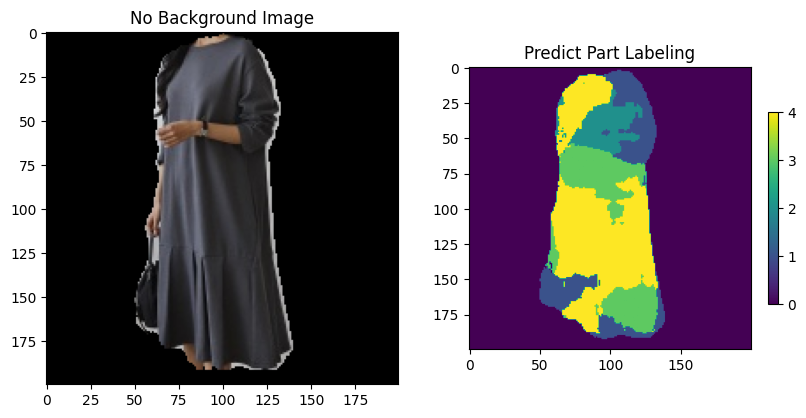

5
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


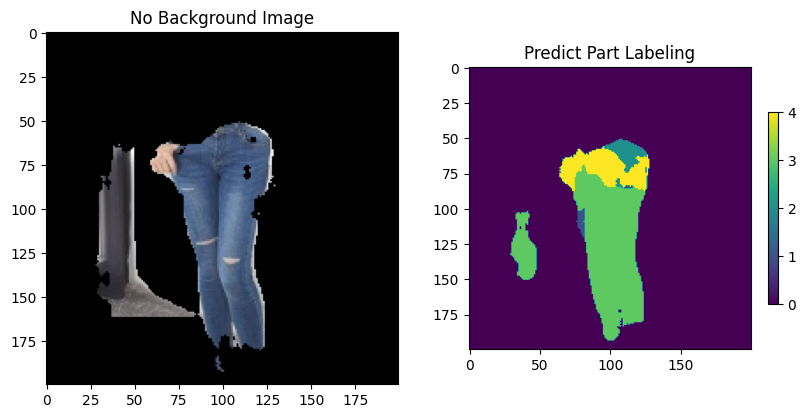

6
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


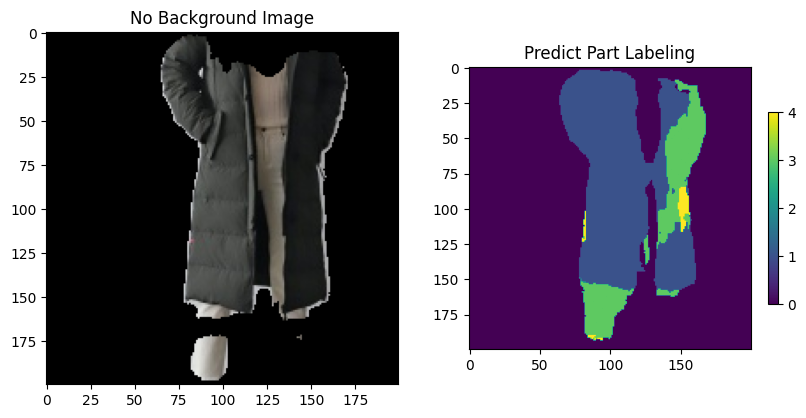

7
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


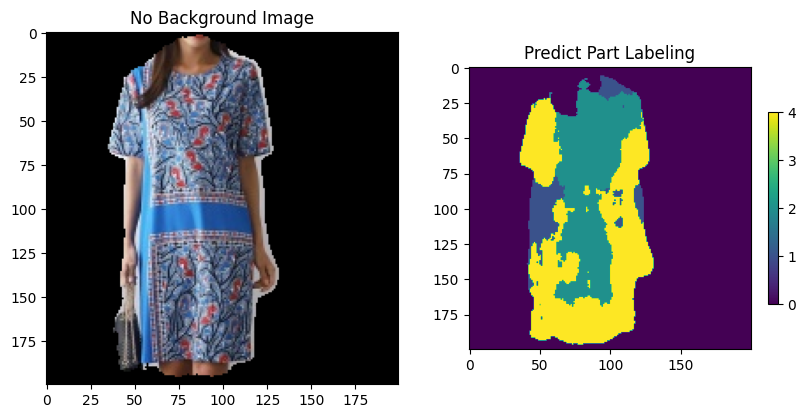

8
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


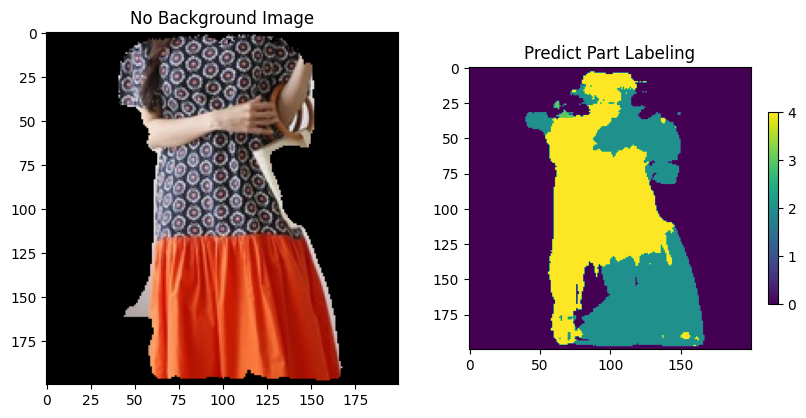

9
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


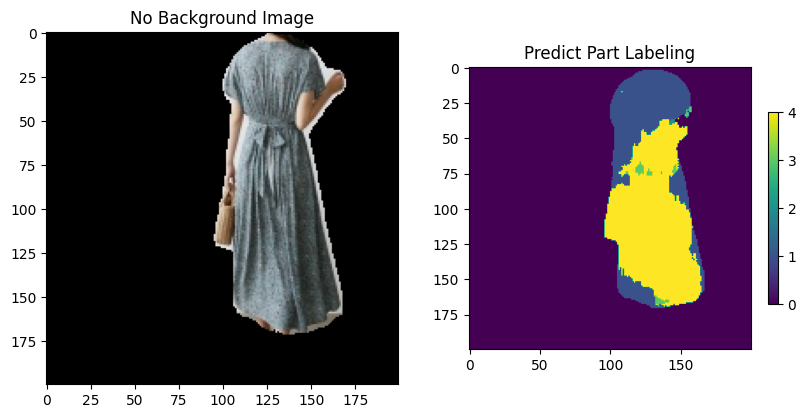

In [52]:
for i in range(len(part_list)):
  print(i)
  print(label_string)
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(no_bg_list[i])
  plt.title("No Background Image")

  plt.subplot(1, 2, 2)
  plt.imshow(part_list[i])
  plt.clim(0, 4)
  plt.colorbar(shrink=0.5)
  plt.title("Predict Part Labeling")

  plt.show()

# 색상을 추출할 파트를 선별하여 color_mask_list에 저장

In [53]:
color_mask_list = []
del_list = []

for i in range(len(part_list)):
  print(np.unique(part_list[i]))

  if 2 in np.unique(part_list[i]):
    mask_part = 2
  elif 1 in np.unique(part_list[i]):
    mask_part = 1
  elif 4 in np.unique(part_list[i]):
    mask_part = 4
  elif 3 in np.unique(part_list[i]):
    mask_part = 3
  else:
    print(str(i) + " image has no cloth part!!")
    del_list.append(i)
    continue

  color_mask = np.zeros(part_list[i].shape, dtype=np.uint8)
  color_mask[part_list[i] == mask_part] = 1

  color_mask_list.append(color_mask)


for i in del_list:
  del ori_list[i]
  del no_bg_list[i]
  del part_list[i]

print("Complete")

[0 1 2 3 4]
[0 2 3 4]
[0 1 2 3 4]
[0 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
[0 2 3 4]
[0 1 2 3 4]
Complete


0
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


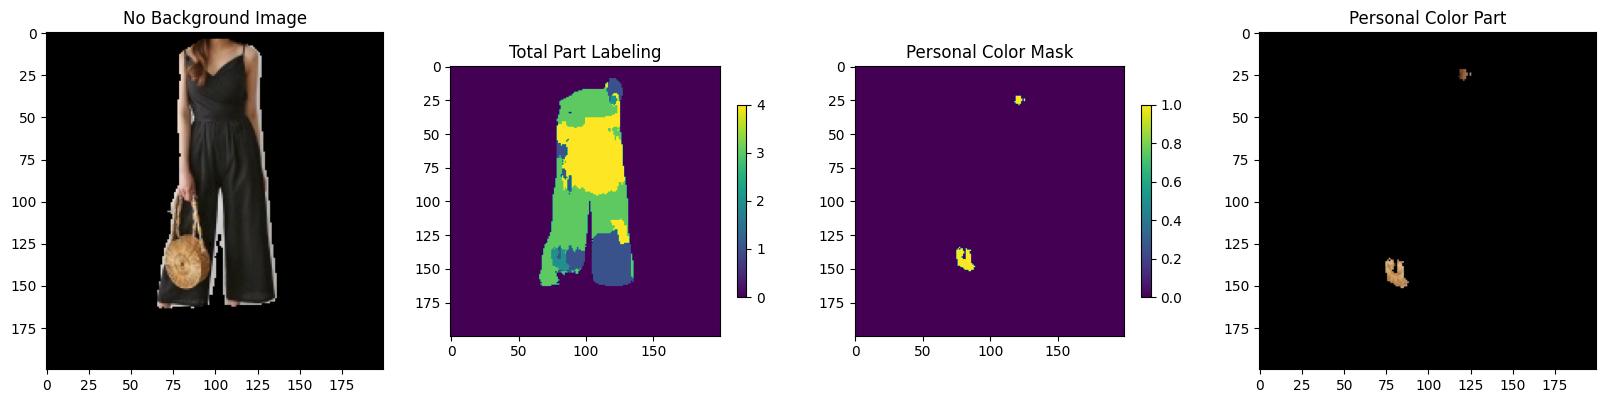

1
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


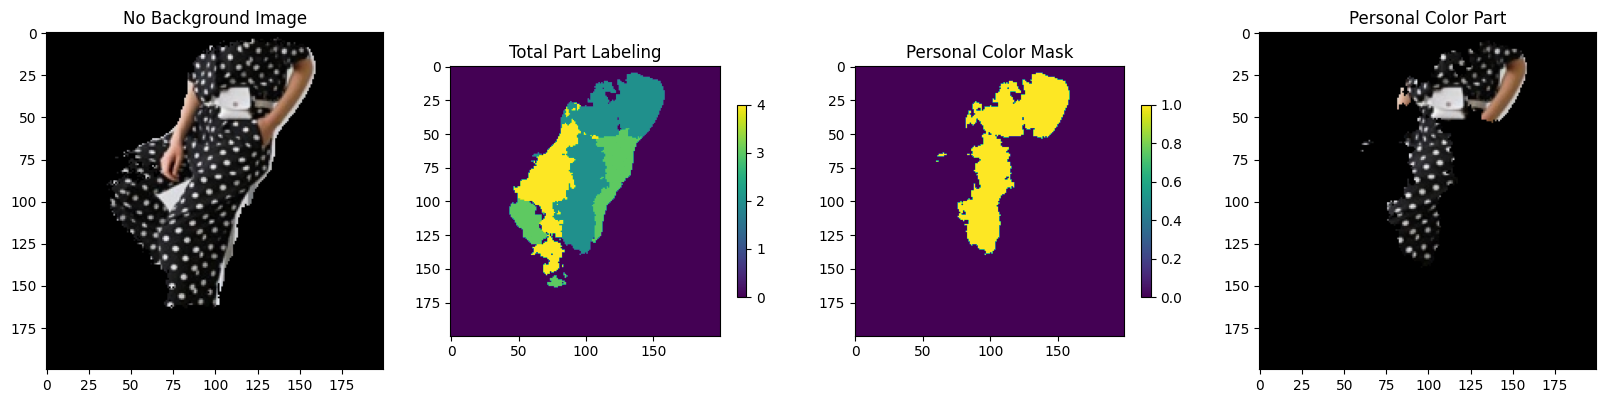

2
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


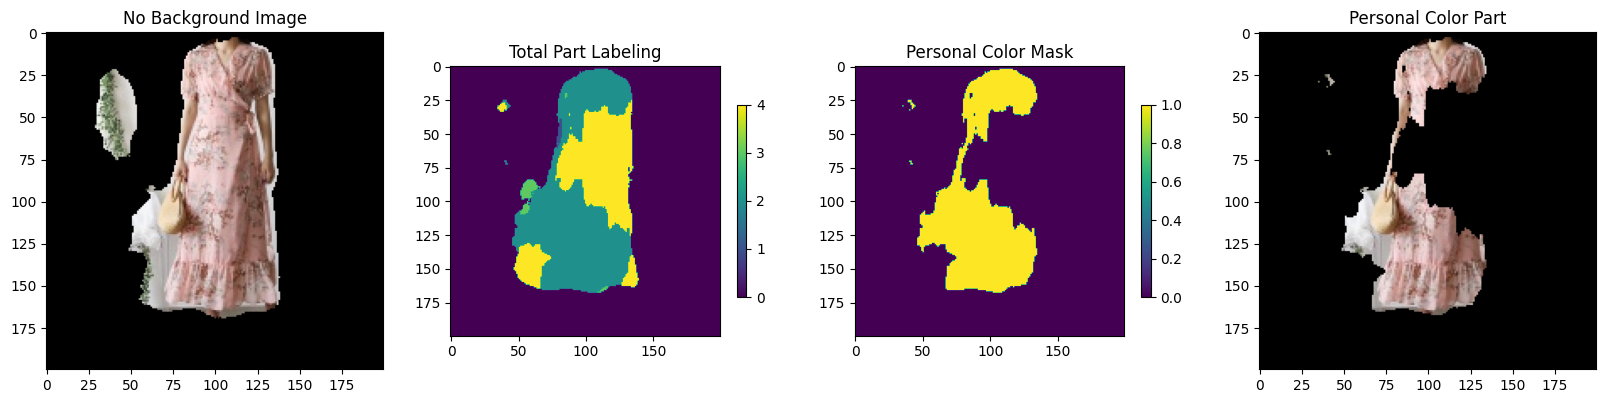

3
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


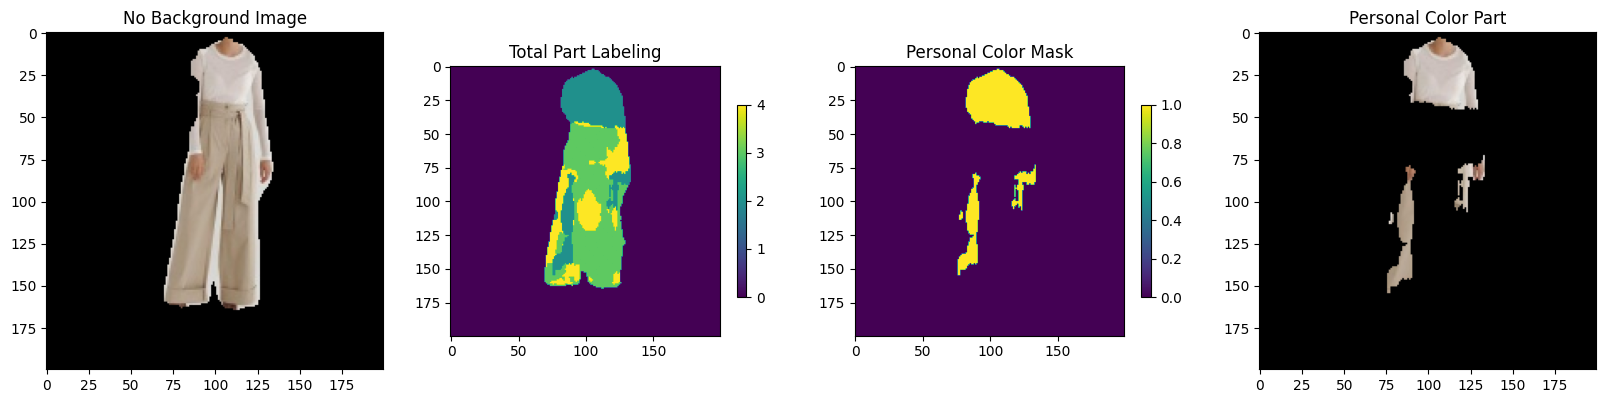

4
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


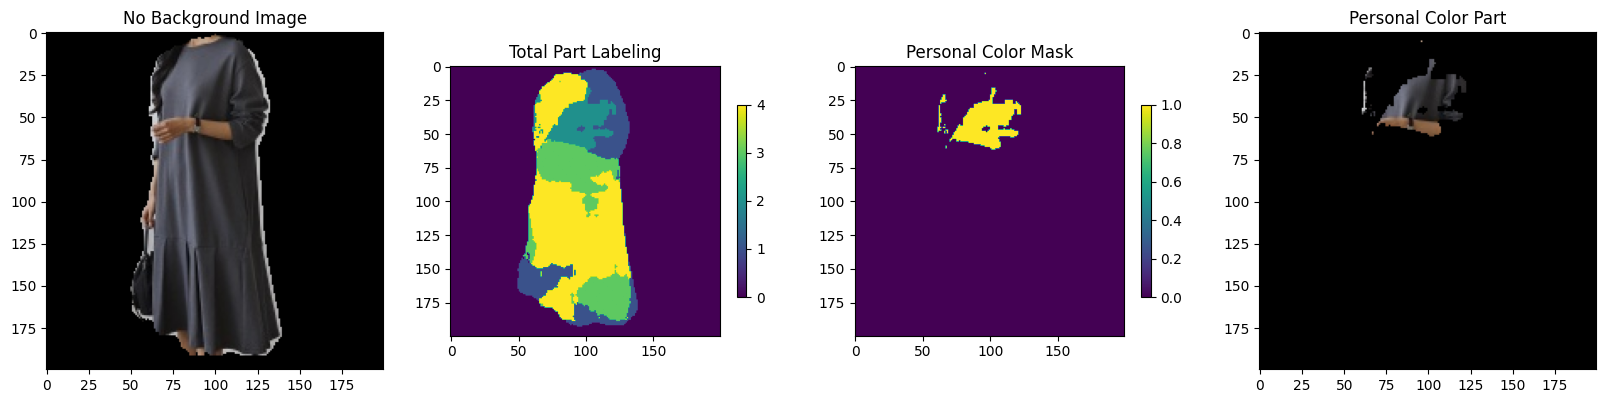

5
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


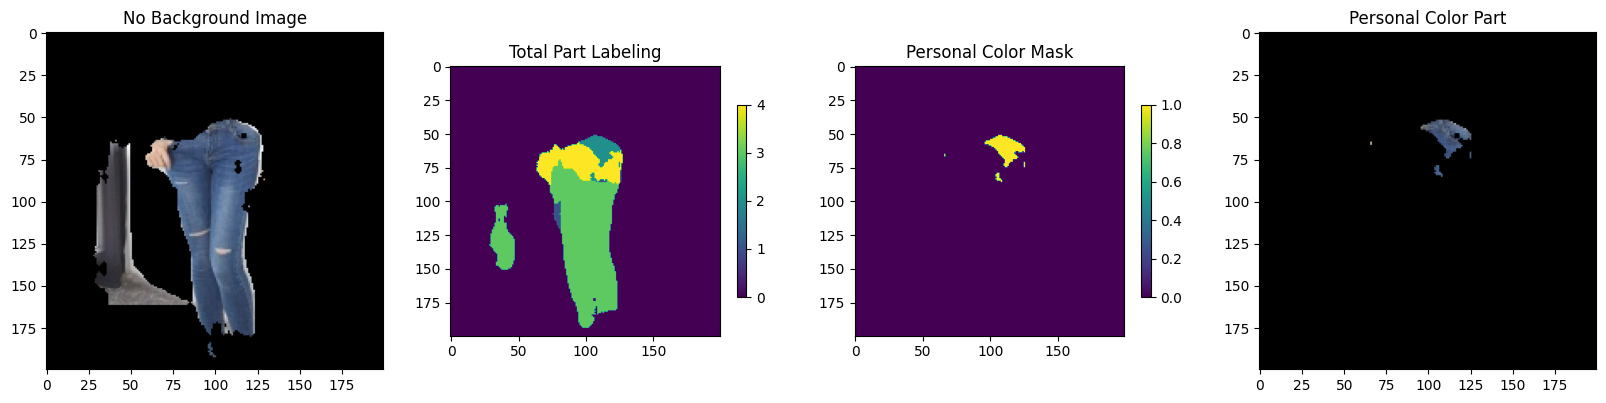

6
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


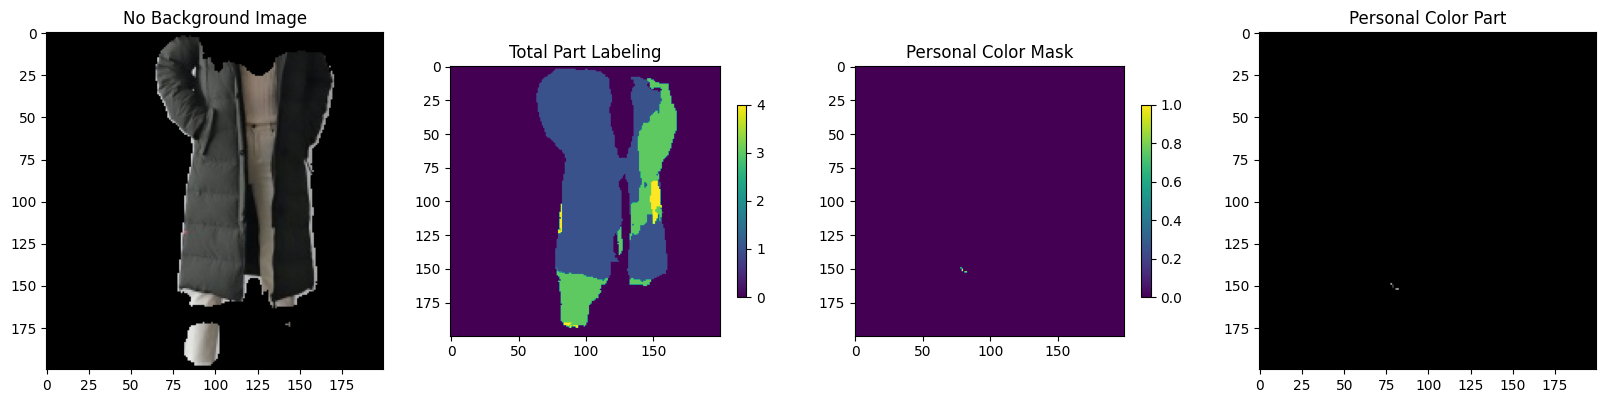

7
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


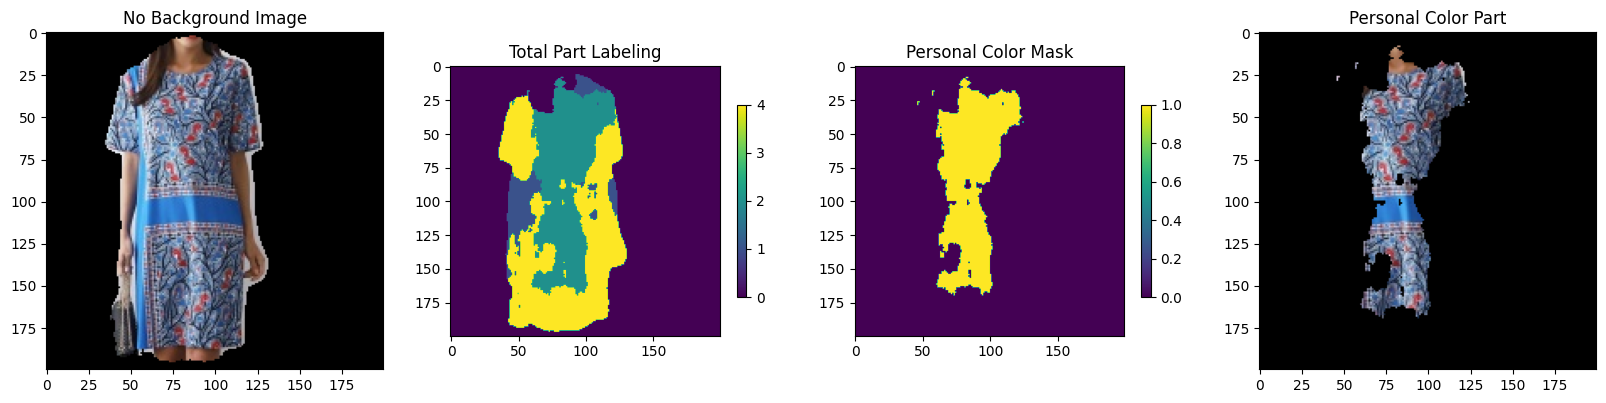

8
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


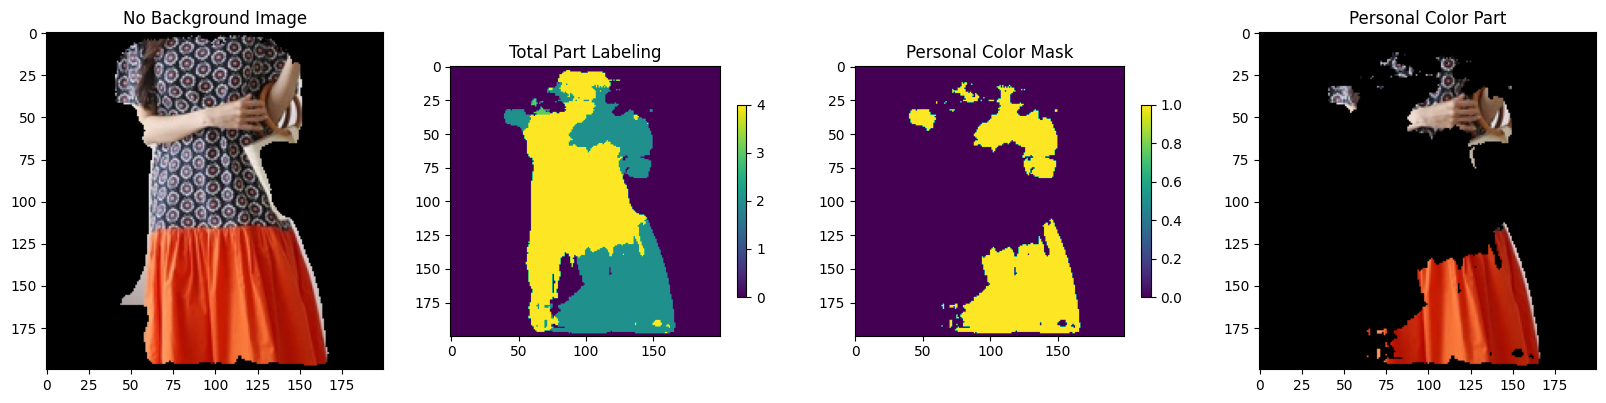

9
0:Background / 1:Outer / 2:Top / 3:Bottom / 4:Onepiece


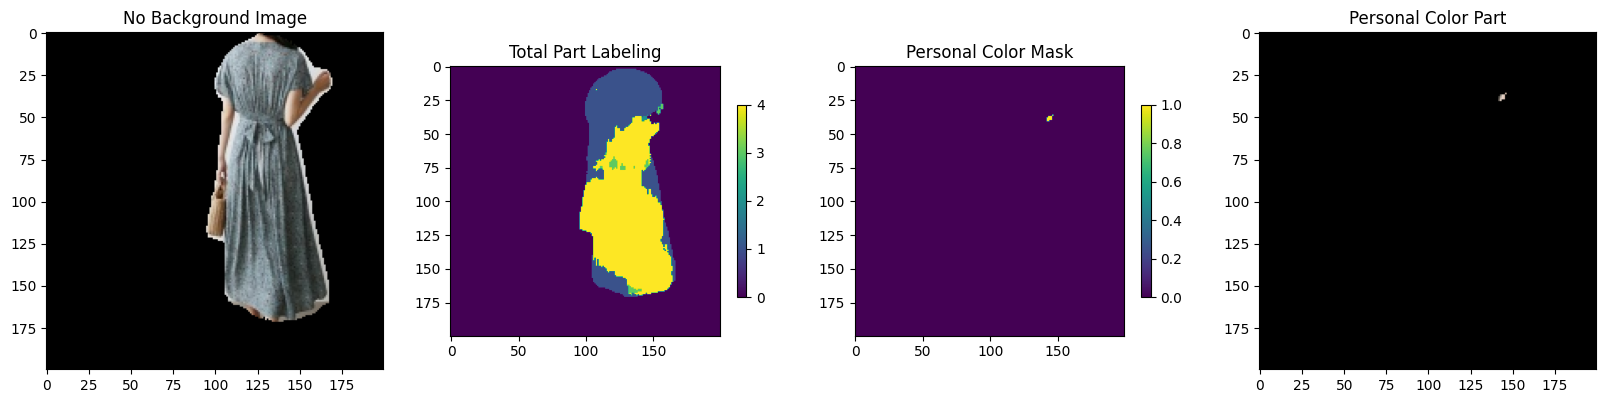

In [58]:
for i in range(len(color_mask_list)):
  print(i)
  print(label_string)
  part_image = cv2.bitwise_and(no_bg_list[i], no_bg_list[i], mask=color_mask_list[i])

  plt.figure(figsize=(20, 5))

  plt.subplot(1, 4, 1)
  plt.imshow(no_bg_list[i])
  plt.title("No Background Image")

  plt.subplot(1, 4, 2)
  plt.imshow(part_list[i])
  plt.clim(0, 4)
  plt.colorbar(shrink=0.5)
  plt.title("Total Part Labeling")

  plt.subplot(1, 4, 3)
  plt.imshow(color_mask_list[i])
  plt.clim(0, 1)
  plt.colorbar(shrink=0.5)
  plt.title("Personal Color Mask")

  plt.subplot(1, 4, 4)
  plt.imshow(part_image)
  plt.title("Personal Color Part")

  plt.show()

# 색상 추출

## 마스크 영역 색상 클러스터링

In [59]:
# 마스크 영역의 픽셀값 추출
total_pixel_list = []

for i in range(0, len(ori_list)):
  pixel_list = []

  for he in range(0, img_height):
    for wi in range(0, img_width):
      if color_mask_list[i][he][wi] == 1:
        r = ori_list[i][he][wi][0]
        g = ori_list[i][he][wi][1]
        b = ori_list[i][he][wi][2]
        pixel_list.append([r, g, b])

  pixel_list = np.array(pixel_list)
  total_pixel_list.append(pixel_list)

print("Complete")

Complete


In [60]:
# 클러스터링
total_predict = []

for i in range(0, len(ori_list)):
  print(str(i+1) + "번째 이미지 색상 클러스터링중...")
  cluster = hierarchy.linkage(total_pixel_list[i], method='centroid', metric='euclidean')
  predict = hierarchy.fcluster(cluster, 70, criterion='distance') # 거리 70까지 cluster 개수 정하기
  total_predict.append(predict)

print("Complete")

1번째 이미지 색상 클러스터링중...
2번째 이미지 색상 클러스터링중...
3번째 이미지 색상 클러스터링중...
4번째 이미지 색상 클러스터링중...
5번째 이미지 색상 클러스터링중...
6번째 이미지 색상 클러스터링중...
7번째 이미지 색상 클러스터링중...
8번째 이미지 색상 클러스터링중...
9번째 이미지 색상 클러스터링중...
10번째 이미지 색상 클러스터링중...
Complete


In [61]:
# 각 군집별 평균 색상 계산
total_cluster_pixel = []

for x in range(0, len(ori_list)):
  cluster_pixel = []
  for i in range(0, len(np.unique(total_predict[x]))):
    cluster_pixel.append([])

  for i in range(0, len(total_predict[x])):
    cluster_pixel[total_predict[x][i]-1].append(total_pixel_list[x][i])

  for i in range(0, len(cluster_pixel)):
    cluster_pixel[i] = np.array(cluster_pixel[i])

  for i in range(0, len(cluster_pixel)):
    cluster_pixel[i] = np.mean(cluster_pixel[i], axis=0)
    cluster_pixel[i] = cluster_pixel[i].astype(int)

  total_cluster_pixel.append(cluster_pixel)

print("Complete")

Complete


In [62]:
# 라벨명과 색상을 빈도순으로 정렬하고 백분율 정보 추가
total_label = []
total_count = []
total_ratio = []

for x in range(0, len(ori_list)):
  # 라벨명과 카운트 정보 추출
  label, count = np.unique(total_predict[x], return_counts=True)

  # 라벨명과 카운트를 딕셔너리화
  count_dict = {}
  for i in range(0, len(label)):
    count_dict[label[i]] = count[i]

  # 딕셔너리 정렬
  sorted_count = sorted(count_dict.items(), key= lambda item:item[1], reverse=True)

  # 정렬된 순서대로 다시 리스트에 저장
  label = []
  count = []
  for item in sorted_count:
    label.append(item[0])
    count.append(item[1])

  # 백분율 계산
  total = np.sum(count)
  ratio = []

  for i in range(0, len(count)):
      ra = (count[i]/total) * 100

      ratio_string = (' %.1f%%' % ra)
      ratio.append(ratio_string)

  # 전체 리스트에 저장
  total_label.append(label)
  total_count.append(count)
  total_ratio.append(ratio)

  # 진행도 확인용
  print(str(x+1) + "번째 이미지 픽셀 정보 계산 완료")

print("Complete")

1번째 이미지 픽셀 정보 계산 완료
2번째 이미지 픽셀 정보 계산 완료
3번째 이미지 픽셀 정보 계산 완료
4번째 이미지 픽셀 정보 계산 완료
5번째 이미지 픽셀 정보 계산 완료
6번째 이미지 픽셀 정보 계산 완료
7번째 이미지 픽셀 정보 계산 완료
8번째 이미지 픽셀 정보 계산 완료
9번째 이미지 픽셀 정보 계산 완료
10번째 이미지 픽셀 정보 계산 완료
Complete


In [63]:
# 각 군집의 평균색상 이미지 생성
total_color_view = []

for x in range(0, len(ori_list)):
  color_view = []

  for i in range(0, len(total_cluster_pixel[x])):
    view = np.full((10, 10, 3), total_cluster_pixel[x][i], dtype=np.uint8)
    color_view.append(view)
  total_color_view.append(color_view)

print("Complete")

Complete


In [68]:
color_mask_image = []

for i in range(0, len(ori_list)):
  masked_image = cv2.bitwise_and(no_bg_list[i], no_bg_list[i], mask=color_mask_list[i])
  color_mask_image.append(masked_image)

print("Complete")

Complete


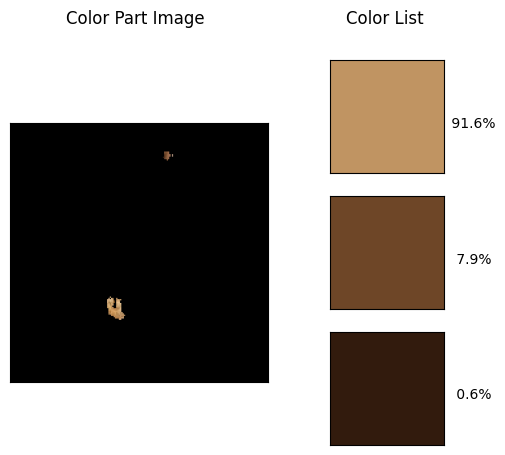

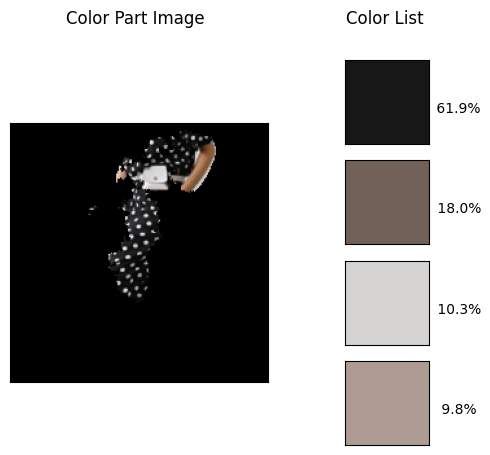

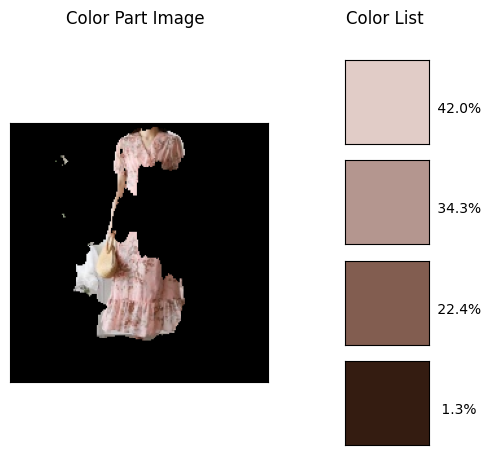

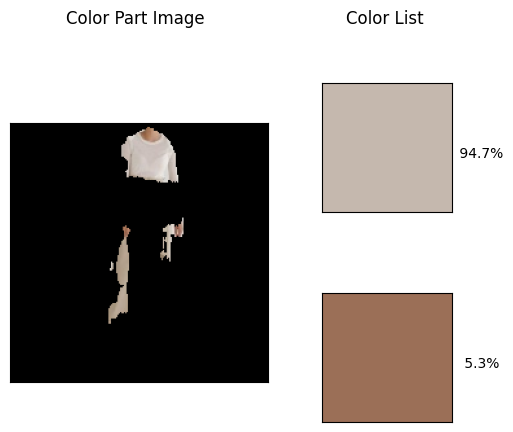

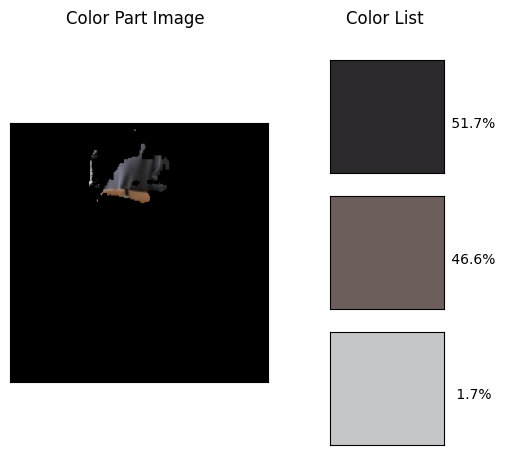

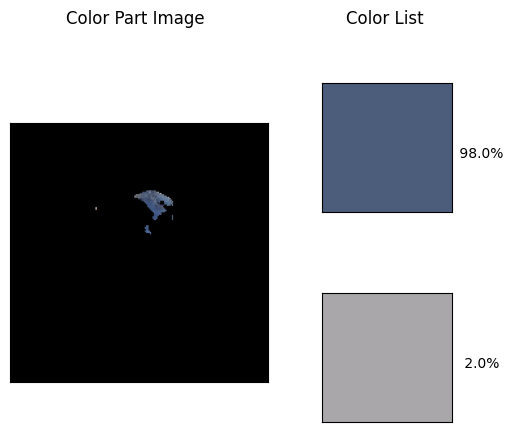

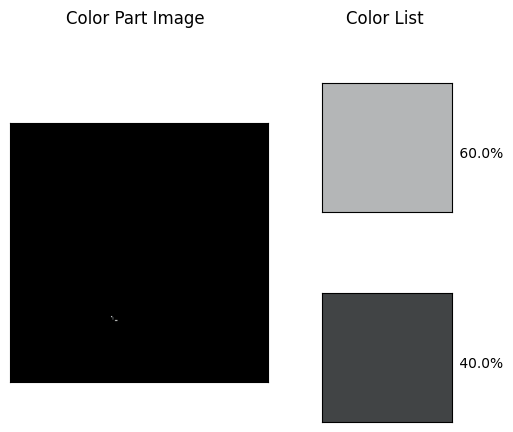

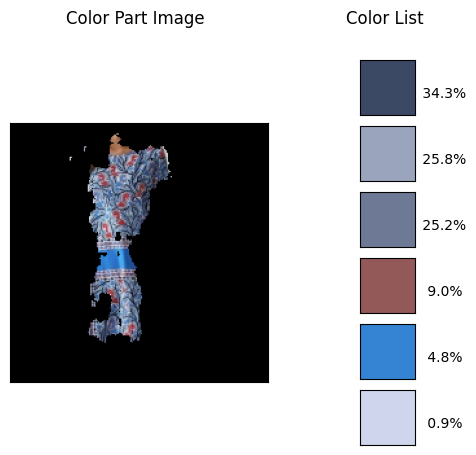

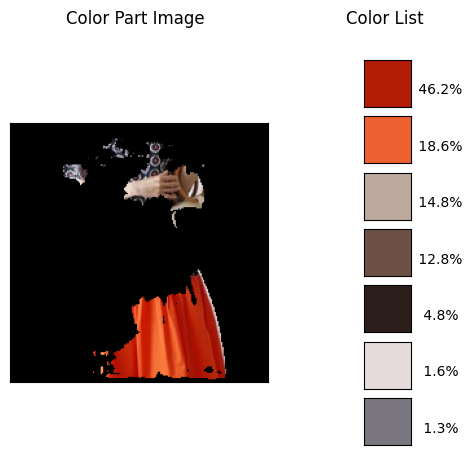

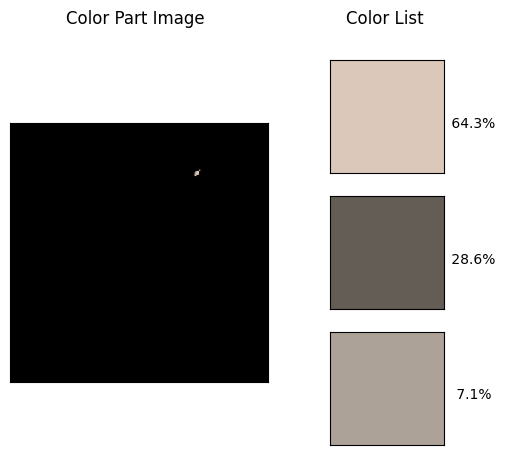

In [75]:
# 그래프 시각화
for x in range(0, len(ori_list)):
  fig = plt.figure(figsize=(5, 5))
  subplots = fig.subfigures(1, 2, width_ratios=[2, 1], wspace=0.0)

  ax1 = subplots[0].subplots(1, 1)
  ax2 = subplots[1].subplots(len(total_label[x]), 1)
  subplots[0].suptitle('Color Part Image')
  subplots[1].suptitle('Color List')

  # 마스크 적용된 원본 이미지 출력
  ax1.imshow(color_mask_image[x])
  ax1.set_xticks([])
  ax1.set_yticks([])

  # 각 군집별 색상과 비율 출력
  for i in range(0, len(total_label[x])):
    ax2[i].imshow(total_color_view[x][(total_label[x][i])-1])
    ax2[i].set_xticks([])
    ax2[i].set_yticks([])
    ax2[i].yaxis.set_label_position('right')
    ax2[i].set_ylabel(str(total_ratio[x][i]), rotation=0, labelpad=20, loc='center')


plt.show()

## 퍼스널 컬러 측정을 위한 대표색 추출

In [70]:
personal_color_list = []

for i in range(0, len(ori_list)):
  # 평균값이 아닌, 중앙값 사용
  median_color = np.median(total_cluster_pixel[i], axis=0)
  personal_color_list.append(median_color)

print("Complete")

Complete


In [71]:
# 컬러뷰 생성
personal_color_view = []

for i in range(0, len(ori_list)):
  view = np.full((10, 10, 3), personal_color_list[i], dtype=np.uint8)
  personal_color_view.append(view)

print("Complete")

Complete


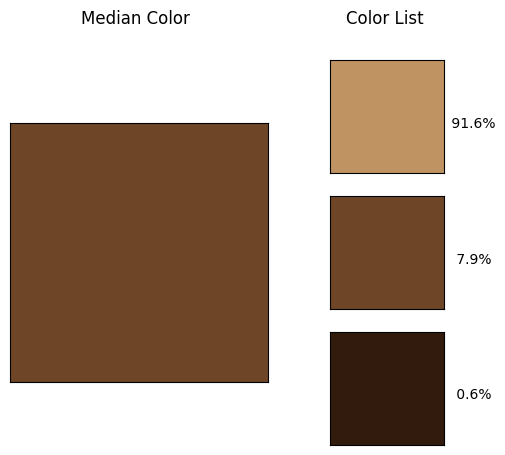

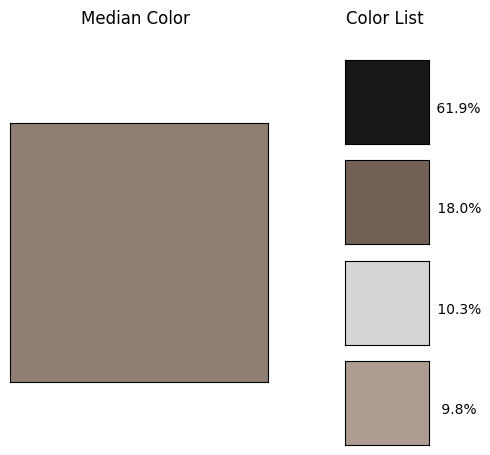

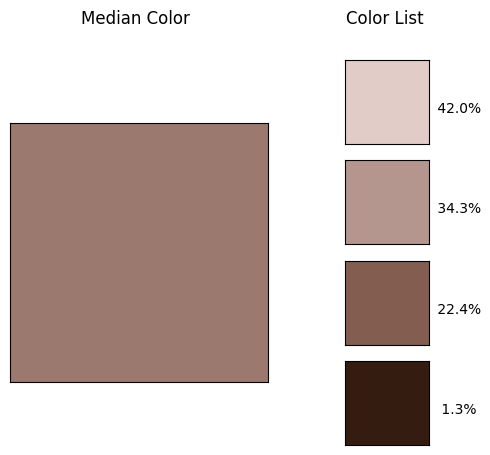

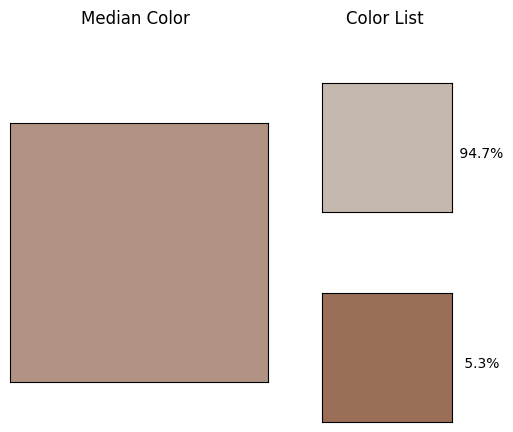

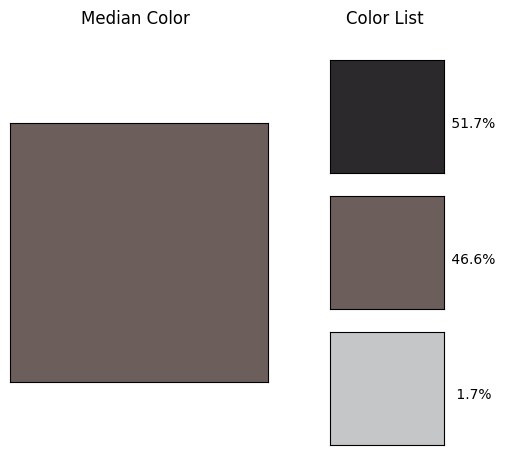

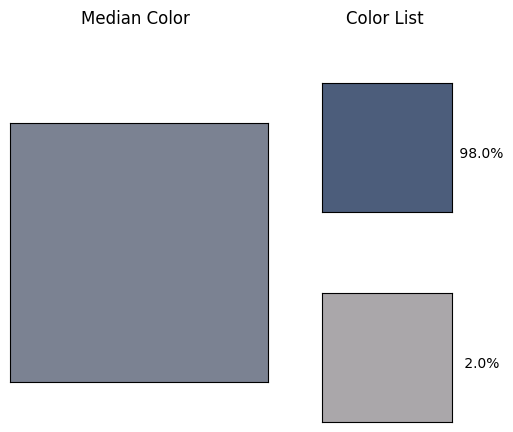

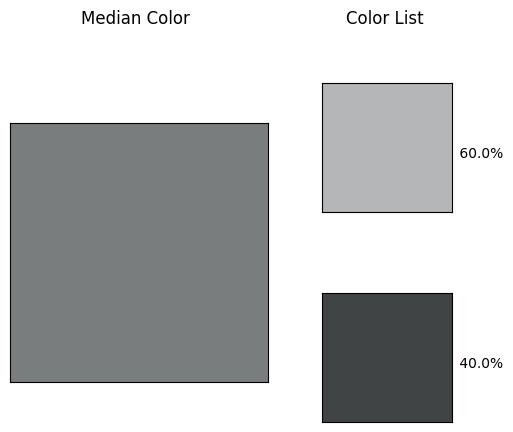

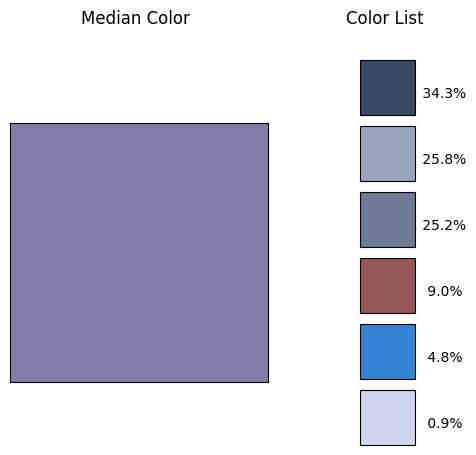

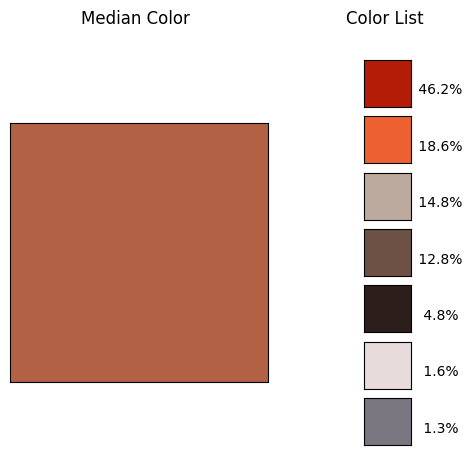

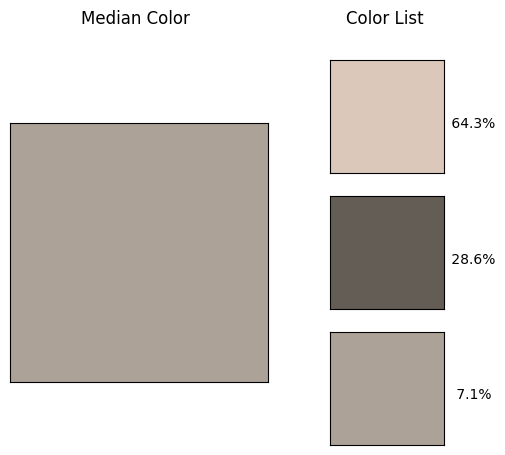

In [77]:
# 그래프 시각화
for x in range(0, len(ori_list)):
  fig = plt.figure(figsize=(5, 5))
  subplots = fig.subfigures(1, 2, width_ratios=[2, 1], wspace=0.0)

  ax1 = subplots[0].subplots(1, 1)
  ax2 = subplots[1].subplots(len(total_label[x]), 1)
  subplots[0].suptitle('Median Color')
  subplots[1].suptitle('Color List')

  # 중앙값 색상 뷰 출력
  ax1.imshow(personal_color_view[x])
  ax1.set_xticks([])
  ax1.set_yticks([])

  # 각 군집별 색상과 비율 출력
  for i in range(0, len(total_label[x])):
    ax2[i].imshow(total_color_view[x][(total_label[x][i])-1])
    ax2[i].set_xticks([])
    ax2[i].set_yticks([])
    ax2[i].yaxis.set_label_position('right')
    ax2[i].set_ylabel(str(total_ratio[x][i]), rotation=0, labelpad=20, loc='center')


plt.show()

## 대표색의 퍼스널 컬러 영역 계산

In [78]:
hsv_color_list = []

for i in range(len(personal_color_view)):
  hsv_view = cv2.cvtColor(personal_color_view[i], cv2.COLOR_RGB2HSV)
  hsv_color = hsv_view[0, 0]

  hsv_color_list.append(hsv_color)

print("Complete")

Complete


In [80]:
for co_list in hsv_color_list:
    print(co_list)

[ 13 165 110]
[ 11  48 143]
[  7  72 155]
[ 11  67 176]
[  5  40 108]
[111  40 146]
[ 98   8 126]
[121  65 169]
[  8 157 179]
[ 15  30 172]


In [87]:
personal_labeling = []

for i in range(len(hsv_color_list)):
  color = hsv_color_list[i]
  h = color[0] # 색상
  s = color[1] # 채도
  v = color[2] # 명도

  # 퍼스널 컬러 영역 계산
  # 3분할 s/v  0 < 85 < 170 < 255
  if h >= 75 and h < 165:
    # 쿨톤
    if v > 170:
      personal_label = 'Summer Light'
    else:
      if s > 170:
        personal_label = 'Winter Bright'
      elif s > 85:
        personal_label = 'Summer Bright'
      else:
        if v < 85:
          personal_label = 'Winter Deep'
        else:
          personal_label = 'Summmer Mute'
  else:
    # 웜톤
    if v < 85:
      personal_label = 'Autumn Deep'
    else:
      if v > 170:
        if s < 85:
          personal_label = 'Spring Light'
        else:
          personal_label = 'Spring Bright'
      else:
        if s > 170:
          personal_label = 'Autumn Strong'
        else:
          personal_label = 'Autumn Mute'


  personal_labeling.append(personal_label)

print("Complete")

Complete


0 : [ 13 165 110]
Personal Color : Autumn Mute


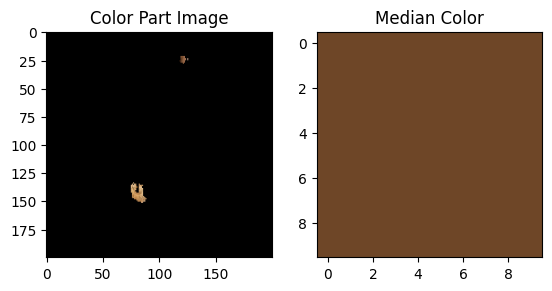


1 : [ 11  48 143]
Personal Color : Autumn Mute


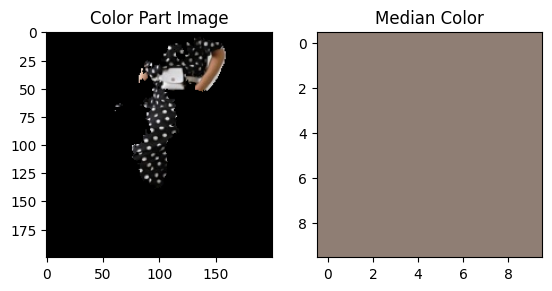


2 : [  7  72 155]
Personal Color : Autumn Mute


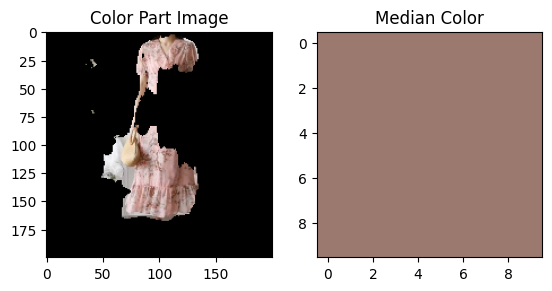


3 : [ 11  67 176]
Personal Color : Spring Light


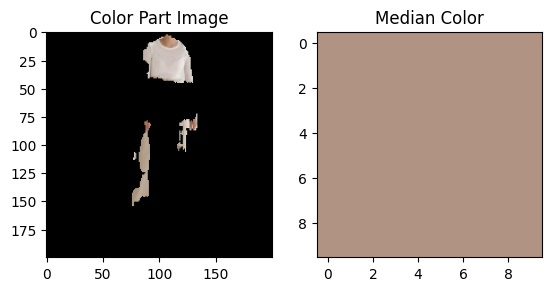


4 : [  5  40 108]
Personal Color : Autumn Mute


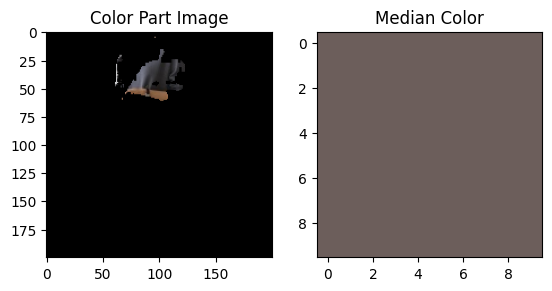


5 : [111  40 146]
Personal Color : Summmer Mute


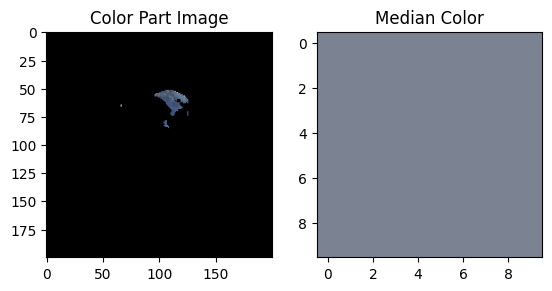


6 : [ 98   8 126]
Personal Color : Summmer Mute


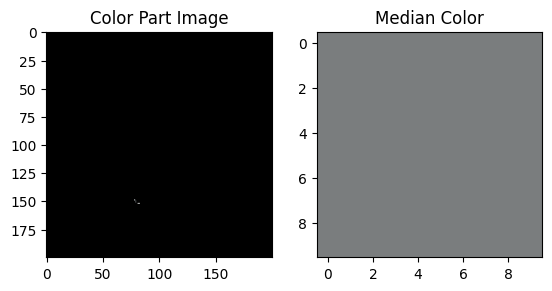


7 : [121  65 169]
Personal Color : Summmer Mute


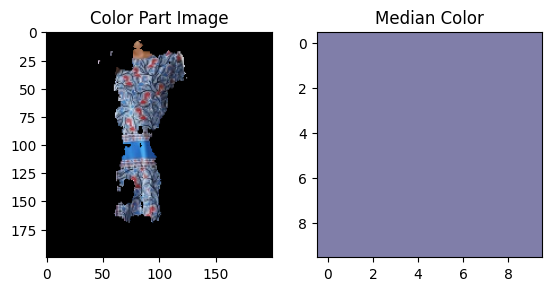


8 : [  8 157 179]
Personal Color : Spring Bright


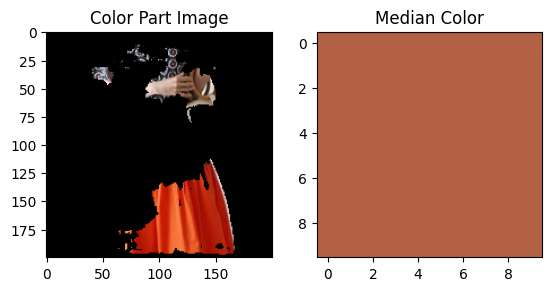


9 : [ 15  30 172]
Personal Color : Spring Light


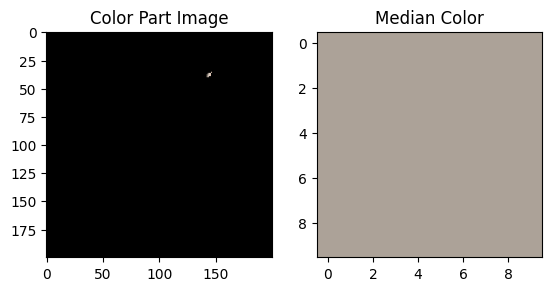

In [88]:
for i in range(len(personal_labeling)):
  print(str(i) + ' : ' + str(hsv_color_list[i]))
  print('Personal Color : ' + personal_labeling[i])
  part_image = cv2.bitwise_and(no_bg_list[i], no_bg_list[i], mask=color_mask_list[i])

  plt.subplot(1, 2, 1)
  plt.imshow(color_mask_image[i])
  plt.title("Color Part Image")

  plt.subplot(1, 2, 2)
  plt.imshow(personal_color_view[i])
  plt.title("Median Color")

  plt.show()
  print()

# 정상 작동 확인